In [1]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import os
import re
import itertools
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
import random

from vocabulary_functions import load_tokenizers

In [2]:
# Initialize pandarallel for parallel processing
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [185]:
# --- Tokenizer and Vocabulary Configuration ---
vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

In [186]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage: 100%|██████████| 30/30 [00:00<00:00, 95.66it/s]


In [187]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_interpro = pd.read_sql(f"SELECT * FROM interpro_entries_v2", conn)
df_interpro = df_interpro[df_interpro['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)
df_interpro['member_databases'] = df_interpro['member_databases'].apply(lambda member_databases: ast.literal_eval(member_databases))

df_prosite = pd.read_sql(f"SELECT * FROM prosite_entries", conn)
df_prosite = df_prosite[df_prosite['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

conn.close()

In [188]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein

Tokenizing Sequences: 100%|██████████| 30/30 [01:17<00:00,  2.58s/it]


,uniprot_id,sequence,BPE 800,BPE 1600,BPE 3200,BPE 6400,BPE 12800,BPE 25600,PUMA blosum62 0.7 0.05 800,PUMA blosum62 0.7 0.05 1600,...,PUMA pre blosum62 0.7 0.05 3200,PUMA pre blosum62 0.7 0.05 6400,PUMA pre blosum62 0.7 0.05 12800,PUMA pre blosum62 0.7 0.05 25600,PUMA pre pam70 0.7 0.05 800,PUMA pre pam70 0.7 0.05 1600,PUMA pre pam70 0.7 0.05 3200,PUMA pre pam70 0.7 0.05 6400,PUMA pre pam70 0.7 0.05 12800,PUMA pre pam70 0.7 0.05 25600
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QR, DL, EA, EH, VL, PSP, ...","[MEL, SA, EYL, REKL, QR, DLEA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...",...,"[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GG, ...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[M, GL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, M...","[MGL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, MH,...","[MGL, EAL, V, PLA, MI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, H,...",...,"[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, HRH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,..."
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, S, LLL, W, F, LL, F, LL, LL, PPL, PV, ...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...",...,"[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RLT, FA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, F...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...",...,"[M, FR, RL, T, FA, QLL, FAT, VLG, IA, GGV, YI,...","[M, FR, RL, TFA, QLL

In [189]:
df_prosite

,prosite_id,uniprot_id,prosite_name,uniprot_name,sequence_start,sequence_end,score,sequence,aligned_sequence
0,PS01199,P62906,RIBOSOMAL_L1,RL10A_HUMAN,117,136,NaN,IKQIPRILGPGLNKAGKFPS,IkqIpriLGpgLNKAGkFPS
1,PS50069,Q9UJX6,CULLIN_2,ANC2_HUMAN,502,700,27.386,ISLLVSIYGSKDLFINEYRSLLADRLLHQFSFSPEREIRNVELLKL...,-----------------...............--------------...
2,PS50069,Q13617,CULLIN_2,CUL2_HUMAN,386,618,61.360,KAPELLAKYCDNLLKKSAKGMTENEVEDRLTSFITVFKYIDDKDVF...,KAPELLAKYCDNLLKKS...............AKGMTENEVEDRLT...
3,PS50069,Q13620,CULLIN_2,CUL4B_HUMAN,558,786,63.828,KPAELIAKYVDSKLRAGNKEATDEELEKMLDKIMIIFRFIYGKDVF...,KPAELIAKYVDSKLRAG...............NKEATDEELEKMLD...
4,PS50069,Q14999,CULLIN_2,CUL7_HUMAN,1215,1506,30.866,HVSEQFARHIDQQIQGSRIGGAQEMERLAQLQQCLQAVLIFSGLEI...,HVSEQFARHIDQQIQGSri...........ggAQEMERLAQLQQCL...
...,...,...,...,...,...,...,...,...,...
47199,PS51321,P23193,TFIIS_CENTRAL,TCEA1_HUMAN,140,256,41.067,VRLKCREMLAAALRTGDDYIAIGADEEELGSQIEEAIYQEIRNTDM...,VRLKCREMLAAALR...................................
47200,PS51321,Q6ZMY3,TFIIS_CENTRAL,SPOC1_HUMAN,608,728,33.705,VRGTVVRSMQEVLWTRLRELPDPVLSEEVVEGIAAGIEAALWDLTQ...,VRGTVVRSMQEVLWtr.................................
47201,PS51486,Q99856,REKLES,ARI3A_HUMAN,444,541,34.376,AALEQLREKLESAEPPEKKMALVADEQQRLMQRALQQNFLAMAAQL...,AALEQLREKLESAEPPEKKMAL........VADEQQRLMQRALQQN...
47202,PS51486,A6NKF2,REKLES,ARI3C_HUMAN,304,389,21.297,LALGPTREKLAPEEPPEKRAVLMGPMDPPRPCMPPSFLPRGKVPLR...,LALGPTREKLAPEEPPEKRAVL........MGPMDPPRPCMPPS--...


In [190]:
df_interpro

,uniprot_id,interpro_id,description,type,member_databases,start_index,end_index
0,B4DNH0,IPR002126,Cadherin-like,domain,"[PS50268, SM00112, PF00028, PR00205]",53,203
1,B4DNH0,IPR002126,Cadherin-like,domain,"[PS50268, SM00112, PF00028, PR00205]",205,329
2,B4DNH0,IPR002126,Cadherin-like,domain,"[PS50268, SM00112, PF00028, PR00205]",319,429
3,B4DNH0,IPR014868,Cadherin prodomain,domain,"[SM01055, PF08758]",27,116
4,B4DNH0,IPR015919,Cadherin-like superfamily,homologous_superfamily,[SSF49313],27,173
...,...,...,...,...,...,...,...
279591,S0BE05,IPR004826,"Basic leucine zipper domain, Maf-type",domain,[PF03131],136,193
279592,S0BE05,IPR004827,Basic-leucine zipper domain,domain,"[PS50217, PS00036, PF00170, SM00338]",169,184
279593,S0BE05,IPR008917,"Transcription factor, Skn-1-like, DNA-binding ...",homologous_superfamily,[SSF47454],125,187
279594,S0BE05,IPR047167,Nuclear Factor Erythroid-derived 2-like,family,[PTHR24411],107,196


In [191]:
# 1. Combine InterPro and PROSITE dataframes
# Rename columns for consistency
df_prosite_renamed = df_prosite.rename(columns={
    'prosite_id': 'reference_id',
    'prosite_name': 'name',
    'sequence_start': 'start_index',
    'sequence_end': 'end_index'
})
df_prosite_renamed['source'] = 'prosite'

df_interpro_renamed = df_interpro.rename(columns={
    'interpro_id': 'reference_id',
    'description': 'name'
})
df_interpro_renamed['source'] = 'interpro'

# Take all InterPro entries. Add a PROSITE entry only if its ID is not in the member_databases of any InterPro entry.
# Get all unique prosite IDs that are mentioned in the InterPro member_databases
all_interpro_prosite_ids = set(
    pid for dbs in df_interpro['member_databases'] for pid in dbs if pid.startswith('PS')
)

# Filter the prosite dataframe to keep only entries whose ID is not in the set from InterPro
prosite_to_add = df_prosite_renamed[~df_prosite_renamed['reference_id'].isin(all_interpro_prosite_ids)]

print(f"Original InterPro entries: {len(df_interpro_renamed)}")
print(f"Original PROSITE entries: {len(df_prosite_renamed)}")
print(f"PROSITE entries to add (not covered by InterPro): {len(prosite_to_add)}")

# Concatenate the two dataframes
df_motifs = pd.concat([
    df_interpro_renamed[['uniprot_id', 'reference_id', 'name', 'start_index', 'end_index', 'source']],
    prosite_to_add[['uniprot_id', 'reference_id', 'name', 'start_index', 'end_index', 'source']]
], ignore_index=True)

print(f"Combined motifs from PROSITE and InterPro: {len(df_motifs)}")
display(df_motifs)

Original InterPro entries: 279596
Original PROSITE entries: 47204
PROSITE entries to add (not covered by InterPro): 2583
Combined motifs from PROSITE and InterPro: 282179


,uniprot_id,reference_id,name,start_index,end_index,source
0,B4DNH0,IPR002126,Cadherin-like,53,203,interpro
1,B4DNH0,IPR002126,Cadherin-like,205,329,interpro
2,B4DNH0,IPR002126,Cadherin-like,319,429,interpro
3,B4DNH0,IPR014868,Cadherin prodomain,27,116,interpro
4,B4DNH0,IPR015919,Cadherin-like superfamily,27,173,interpro
...,...,...,...,...,...,...
282174,Q9H7Z7,PS51354,GLUTAREDOXIN_2,90,193,prosite
282175,Q9H299,PS51354,GLUTAREDOXIN_2,1,93,prosite
282176,P35754,PS51354,GLUTAREDOXIN_2,3,106,prosite
282177,P09874,PS52007,PADR1,225,359,prosite


In [192]:
# 2. Pre-calculate token spans for each model
# This assumes that joining tokens reconstructs the original sequence.
def get_token_spans(tokens):
    spans = []
    current_pos = 0
    for token in tokens:
        start = current_pos
        end = start + len(token)
        spans.append((start, end))
        current_pos = end
    return spans

for model_name in tqdm(tokenizer_list.keys(), desc="Calculating Token Spans"):
    df_protein[f'{model_name}_spans'] = df_protein[model_name].parallel_apply(get_token_spans)

Calculating Token Spans:   0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [193]:
df_protein.head()

,uniprot_id,sequence,BPE 800,BPE 1600,BPE 3200,BPE 6400,BPE 12800,BPE 25600,PUMA blosum62 0.7 0.05 800,PUMA blosum62 0.7 0.05 1600,...,PUMA pam70 0.7 0.05 3200_spans,PUMA pam70 0.7 0.05 6400_spans,PUMA pam70 0.7 0.05 12800_spans,PUMA pam70 0.7 0.05 25600_spans,PUMA pre pam70 0.7 0.05 800_spans,PUMA pre pam70 0.7 0.05 1600_spans,PUMA pre pam70 0.7 0.05 3200_spans,PUMA pre pam70 0.7 0.05 6400_spans,PUMA pre pam70 0.7 0.05 12800_spans,PUMA pre pam70 0.7 0.05 25600_spans
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QR, DL, EA, EH, VL, PSP, ...","[MEL, SA, EYL, REKL, QR, DLEA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...",...,"[(0, 3), (3, 5), (5, 8), (8, 9), (9, 12), (12,...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1...","[(0, 1), (1, 3), (3, 5), (5, 6), (6, 8), (8, 9...","[(0, 1), (1, 3), (3, 5), (5, 8), (8, 9), (9, 1...","[(0, 3), (3, 5), (5, 8), (8, 9), (9, 12), (12,...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1...","[(0, 3), (3, 5), (5, 8), (8, 12), (12, 16), (1..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[M, GL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, M...","[MGL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, MH,...","[MGL, EAL, V, PLA, MI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, H,...",...,"[(0, 3), (3, 6), (6, 7), (7, 9), (9, 12), (12,...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1...","[(0, 1), (1, 3), (3, 6), (6, 7), (7, 9), (9, 1...","[(0, 3), (3, 6), (6, 7), (7, 9), (9, 12), (12,...","[(0, 3), (3, 6), (6, 7), (7, 9), (9, 12), (12,...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1...","[(0, 3), (3, 7), (7, 9), (9, 12), (12, 14), (1..."
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, S, LLL, W, F, LL, F, LL, LL, PPL, PV, ...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...",...,"[(0, 1), (1, 3), (3, 7), (7, 8), (8, 11), (11,...","[(0, 3), (3, 7), (7, 8), (8, 11), (11, 14), (1...","[(0, 3), (3, 7), (7, 11), (11, 14), (14, 16), ...","[(0, 3), (3, 7), (7, 11), (11, 14), (14, 16), ...","[(0, 1), (1, 3), (3, 4), (4, 7), (7, 8), (8, 1...","[(0, 1), (1, 3), (3, 7), (7, 8), (8, 11), (11,...","[(0, 3), (3, 7), (7, 8), (8, 11), (11, 14), (1...","[(0, 3), (3, 7), (7, 8), (8, 11), (11, 14), (1...","[(0, 3), (3, 7), (7, 11), (11, 14), (14, 16), ...","[(0, 3), (3, 7), (7, 11), (11, 14), (14, 16), ..."
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RLT, FA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, F...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...",...,"[(0, 1), (1, 3), (3, 5), (5, 6), (6, 8),

In [194]:
# 3. Merge motif data with protein data
df_analysis = pd.merge(df_motifs, df_protein, on='uniprot_id', how='inner')
print(f"Merged motifs with protein data: {len(df_analysis)}")
df_analysis.head()

Merged motifs with protein data: 282179


,uniprot_id,reference_id,name,start_index,end_index,source,sequence,BPE 800,BPE 1600,BPE 3200,...,PUMA pam70 0.7 0.05 3200_spans,PUMA pam70 0.7 0.05 6400_spans,PUMA pam70 0.7 0.05 12800_spans,PUMA pam70 0.7 0.05 25600_spans,PUMA pre pam70 0.7 0.05 800_spans,PUMA pre pam70 0.7 0.05 1600_spans,PUMA pre pam70 0.7 0.05 3200_spans,PUMA pre pam70 0.7 0.05 6400_spans,PUMA pre pam70 0.7 0.05 12800_spans,PUMA pre pam70 0.7 0.05 25600_spans
0,B4DNH0,IPR002126,Cadherin-like,53,203,interpro,MGPWSRSLSALLLLLQVSSWLCQEPEPCHPGFDAESYTFTVPRRHL...,"[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SRSL, SALL, LLL, QV, SS, WL, CQ, EPE,...",...,"[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1..."
1,B4DNH0,IPR002126,Cadherin-like,205,329,interpro,MGPWSRSLSALLLLLQVSSWLCQEPEPCHPGFDAESYTFTVPRRHL...,"[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SRSL, SALL, LLL, QV, SS, WL, CQ, EPE,...",...,"[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1..."
2,B4DNH0,IPR002126,Cadherin-like,319,429,interpro,MGPWSRSLSALLLLLQVSSWLCQEPEPCHPGFDAESYTFTVPRRHL...,"[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SRSL, SALL, LLL, QV, SS, WL, CQ, EPE,...",...,"[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1..."
3,B4DNH0,IPR014868,Cadherin prodomain,27,116,interpro,MGPWSRSLSALLLLLQVSSWLCQEPEPCHPGFDAESYTFTVPRRHL...,"[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SRSL, SALL, LLL, QV, SS, WL, CQ, EPE,...",...,"[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10,...","[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1..."
4,B4DNH0,IPR015919,Cadherin-like superfamily,27,173,interpro,MGPWSRSLSALLLLLQVSSWLCQEPEPCHPGFDAESYTFTVPRRHL...,"[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SR, SL, SA, LL, LLL, QV, SS, WL, CQ, ...","[MG, PW, SRSL, SALL, LLL, QV, SS, WL, CQ, EPE,...",...,"[(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12,...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4), (4, 8), (8, 12), (12, 15), (1...","[(0, 2), (2, 4

In [195]:
# 4. Extract subsequences and tokens for each motif
def extract_motif_tokens(row):
    motif_start = row['start_index'] - 1  # Convert to 0-based
    motif_end = row['end_index']
    
    # Ensure indices are within sequence bounds
    seq_len = len(row['sequence'])
    motif_start = max(0, motif_start)
    motif_end = min(seq_len, motif_end)

    row['sub_sequence'] = row['sequence'][motif_start:motif_end]
    
    for model_name in tokenizer_list.keys():
        model_tokens = []
        model_token_spans = []
        
        all_token_spans = row[f'{model_name}_spans']
        all_tokens = row[model_name]
        
        for i, (token_start, token_end) in enumerate(all_token_spans):
            # Check for overlap: (start1 < end2) and (start2 < end1)
            if token_start < motif_end and motif_start < token_end:
                model_tokens.append(all_tokens[i])
                model_token_spans.append((token_start, token_end))
        
        row[f'{model_name}_tokens'] = model_tokens
        row[f'{model_name}_spans_motif'] = model_token_spans
        
    return row

print("Extracting tokens for each motif...")
df_analysis = df_analysis.parallel_apply(extract_motif_tokens, axis=1)

Extracting tokens for each motif...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [207]:
exact_match_mask

4537       True
4538       True
4539       True
4540      False
4541      False
          ...  
281045     True
281052     True
281058     True
281074     True
281075     True
Length: 281, dtype: bool

In [218]:
# 5. Perform analyses and calculate metrics
print("--- Calculating Metrics ---")
results = defaultdict(dict)

for model_name in tqdm(tokenizer_list.keys(), desc="Analyzing Models"):
    # Exp 1: One-to-one match
    one_to_one_mask = (df_analysis[f'{model_name}_tokens'].apply(len) == 1)
    exact_match_mask = df_analysis[one_to_one_mask].apply(
        lambda row: row[f'{model_name}_tokens'][0] == row['sub_sequence'] if row['sub_sequence'] else False,
        axis=1
    )
    one_to_one_matches = exact_match_mask.sum() if len(exact_match_mask) > 0 else 0

    # Exp 2: Boundary Adherence
    adherent_count = 0
    adherent_token_counts = []
    for _, row in df_analysis.iterrows():
        motif_spans = row[f'{model_name}_spans_motif']
        if not motif_spans:
            continue
        
        tokens_start = motif_spans[0][0]
        tokens_end = motif_spans[-1][1]
        
        motif_start = row['start_index'] - 1
        motif_end = row['end_index']
        
        if tokens_start == motif_start and tokens_end == motif_end:
            adherent_count += 1
            adherent_token_counts.append(len(motif_spans))

    # # Exp 3: Jaccard Overlap Score
    # jaccard_scores = []
    # for _, row in df_analysis.iterrows():
    #     motif_start = row['start_index'] - 1
    #     motif_end = row['end_index']
    #     motif_set = set(range(motif_start, motif_end))
        
    #     tokens_set = set()
    #     for start, end in row[f'{model_name}_spans_motif']:
    #         tokens_set.update(range(start, end))
        
    #     intersection = len(motif_set.intersection(tokens_set))
    #     union = len(motif_set.union(tokens_set))
    #     jaccard_scores.append(intersection / union if union > 0 else 0)

    # Exp 4: Motif Fragmentation
    avg_fragmentation = df_analysis[f'{model_name}_tokens'].apply(len).mean()

    # Exp 5: Average Token Length in Motifs
    all_motif_tokens = list(itertools.chain.from_iterable(df_analysis[f'{model_name}_tokens']))
    token_lengths = [len(token) for token in all_motif_tokens]
    avg_token_length_in_motifs = np.mean(token_lengths) if token_lengths else 0

    # Store results
    total_motifs = len(df_analysis)
    results[model_name]['One-to-one Match (%)'] = (one_to_one_matches / total_motifs * 100) if total_motifs else 0
    results[model_name]['Boundary Adherence (%)'] = (adherent_count / total_motifs * 100) if total_motifs else 0
    results[model_name]['Avg Tokens in Adherent'] = np.mean(adherent_token_counts) if adherent_token_counts else 0
    # results[model_name]['Avg Jaccard Score'] = np.mean(jaccard_scores) if jaccard_scores else 0
    results[model_name]['Avg Motif Fragmentation'] = avg_fragmentation
    results[model_name]['Avg Token Length in Motifs'] = avg_token_length_in_motifs

--- Calculating Metrics ---


Analyzing Models: 100%|██████████| 30/30 [03:55<00:00,  7.83s/it]


In [220]:
# 6. Display results
df_results = pd.DataFrame(results).T
print("--- Motif Detection Evaluation Results ---")
display(df_results)

# # Optional: Save results to a file
df_results.to_csv("motif_detection_results.csv")
print("Results saved to motif_detection_results.csv")

--- Motif Detection Evaluation Results ---


,One-to-one Match (%),Boundary Adherence (%),Avg Tokens in Adherent,Avg Motif Fragmentation,Avg Token Length in Motifs
BPE 800,0.000000,31.239745,75.594995,70.332144,1.932529
BPE 1600,0.000000,26.998820,70.095176,64.392765,2.113296
BPE 3200,0.002126,23.691699,65.717260,59.565949,2.287473
BPE 6400,0.005670,21.398120,61.939766,55.848249,2.442922
BPE 12800,0.042172,19.312918,58.307889,52.060047,2.625364
BPE 25600,0.050677,17.318794,54.520135,48.178121,2.842954
PUMA blosum62 0.7 0.05 800,0.000000,32.682801,77.565308,72.359644,1.877313
PUMA blosum62 0.7 0.05 1600,0.000000,28.310753,71.778863,66.219311,2.054626
PUMA blosum62 0.7 0.05 3200,0.002126,24.654563,67.391160,60.908530,2.236344
PUMA blosum62 0.7 0.05 6400,0.002481,22.108307,63.660399,57.129223,2.387119


Results saved to motif_detection_results.csv


In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

In [222]:
df_results.loc[f'{'BPE'} {3200}', 'One-to-one Match (%)']

np.float64(0.002126309895491869)

/tmp/ipykernel_1004603/3765600920.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(vocab_sizes, [df_results.loc[f'{method} {vs}', metric] for vs in vocab_sizes],
/tmp/ipykernel_1004603/3765600920.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(vocab_sizes, [df_results.loc[f'{method} {vs}', metric] for vs in vocab_sizes],
/tmp/ipykernel_1004603/3765600920.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "*--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(vocab_sizes, [df_results.loc[f'{method} {vs}', metric] for vs in vocab_sizes],
/tmp/ipykernel_1004603/3765600920.py:8: UserWarning: linestyle is redundantly defined by the 'lin

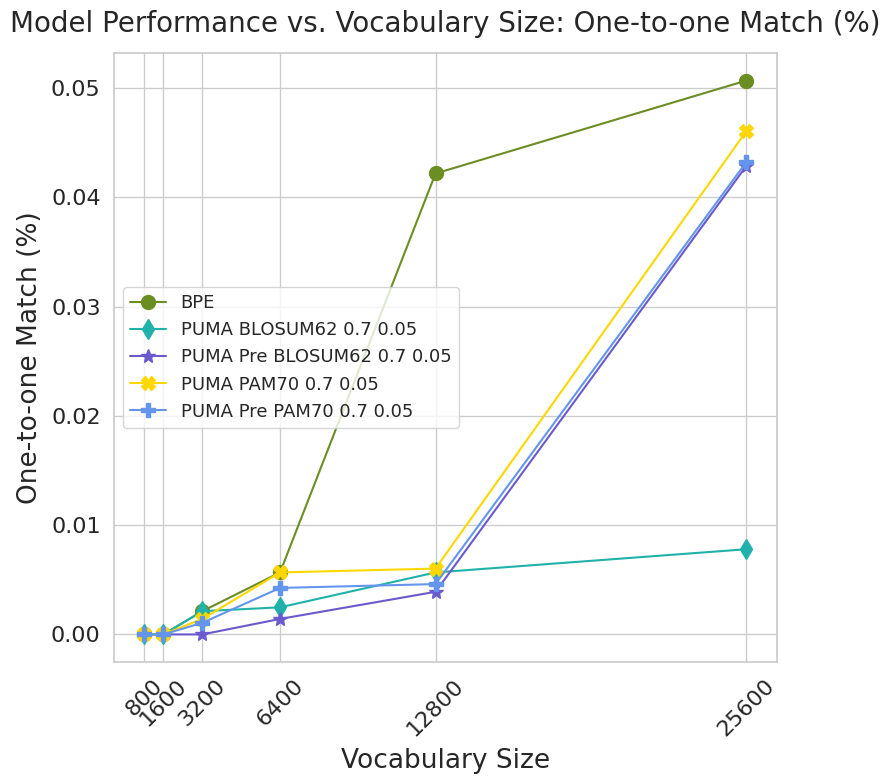

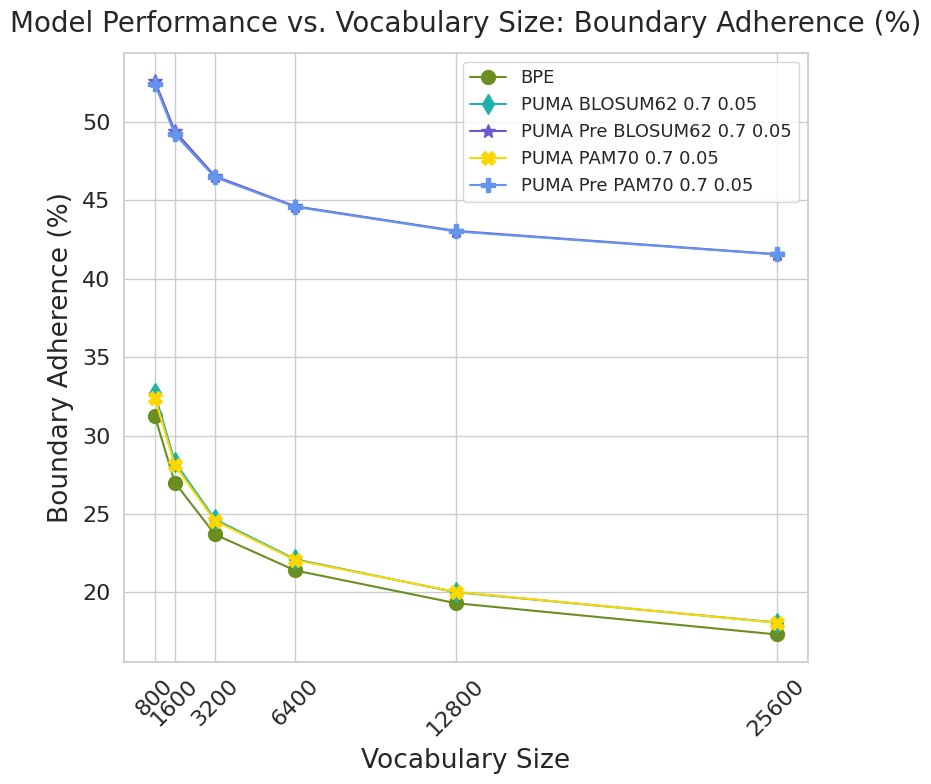

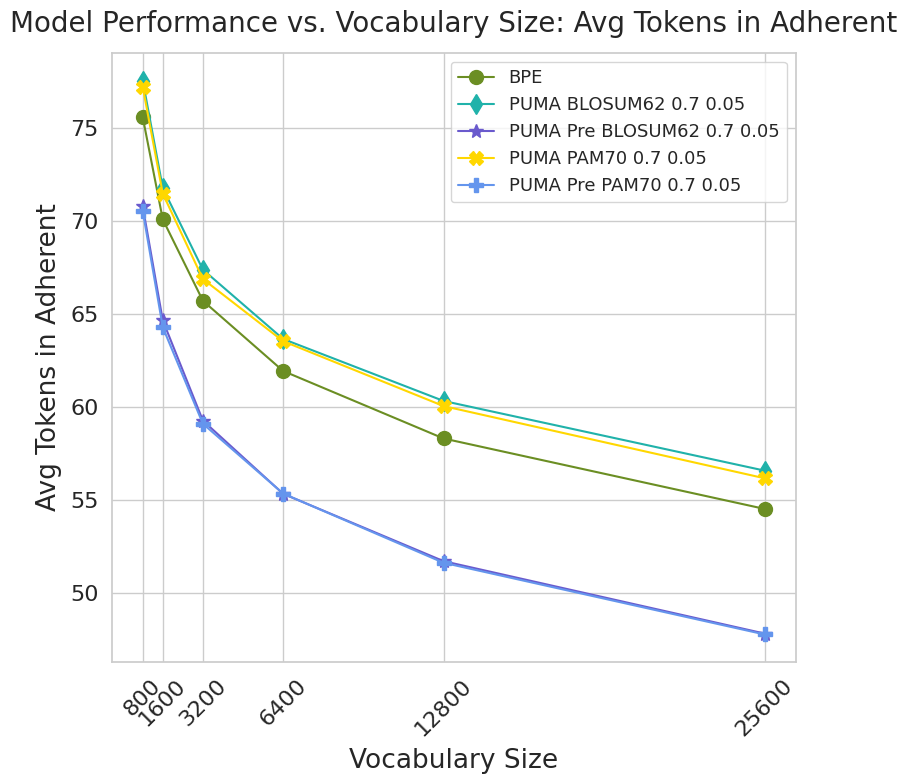

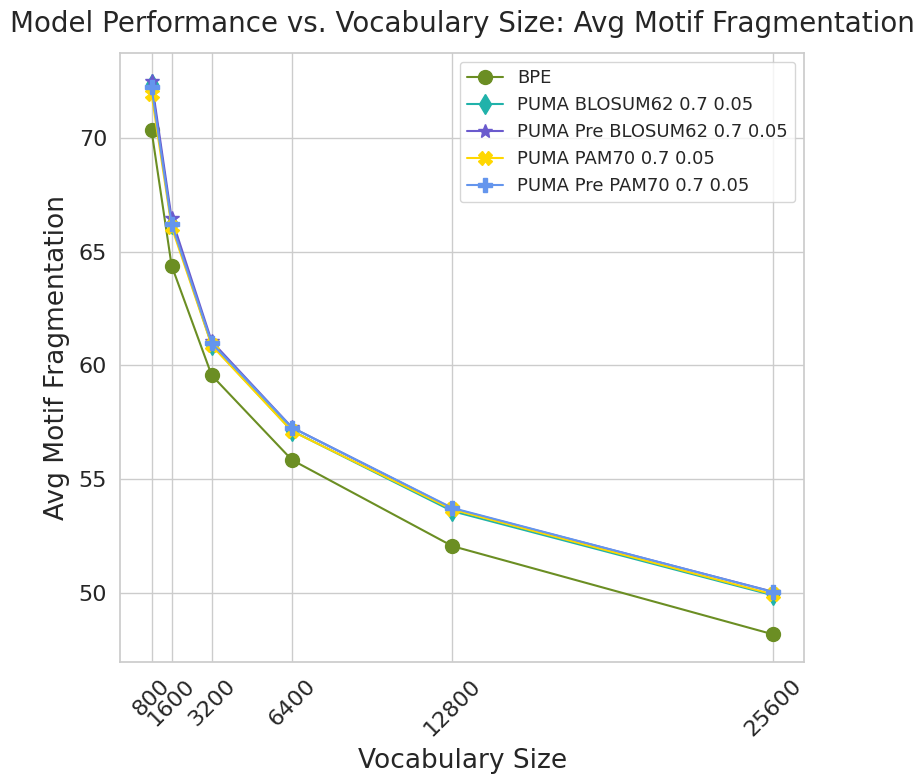

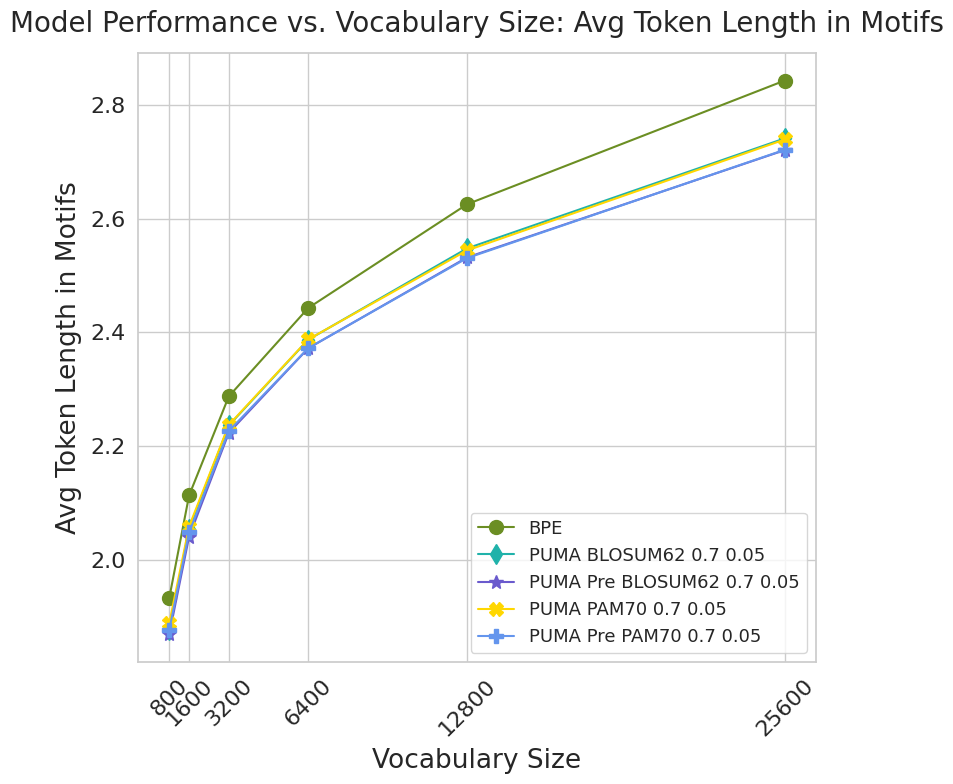

In [224]:
sns.set_style("whitegrid")

for metric in df_results.columns:
    plt.figure()
    for i, method in enumerate(methods):
        method_name = methods2names.get(method, method)
        # Standard BERTopic
        plt.plot(vocab_sizes, [df_results.loc[f'{method} {vs}', metric] for vs in vocab_sizes],
                    markers[i], color=colors[i], markersize=10, linestyle='-', label=f'{method_name}')

    plt.title(f'Model Performance vs. Vocabulary Size: {metric}', pad=title_pad)
    plt.xlabel("Vocabulary Size", labelpad=label_pad)
    plt.ylabel(metric, labelpad=label_pad)
    plt.xticks(vocab_sizes, rotation=45)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{figures_folder}/dice_domains.eps', bbox_inches='tight')
    # plt.savefig(f'{figures_folder}/dice_domains.pdf', bbox_inches='tight')
    # plt.savefig(f'{figures_folder}/dice_domains.png', bbox_inches='tight')
    plt.show()